In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from neural_odes import *
from tqdm import tqdm_notebook as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simple Explicit ODE Solvers to solve $\frac{dy}{dt} = f(t,y) = \cos(2\pi t) \iff y(t) = \frac{1}{2 \pi} \sin(2 \pi t) + y_0$

In [2]:
dt = 0.01
t0 = 0
y0 = torch.Tensor([1.0]).float()
Tn = 1
t = torch.arange(t0, Tn+dt, dt).float()
N = len(t)

In [3]:
print(f'The number of time steps = {N-1}')

The number of time steps = 100


### 1) 4 stage explicit Runge Kutta

In [4]:
# Define function
# Problem is this is a lambda function and can onyl learn nd array
f = lambda t,y : torch.cos(2*math.pi*t)

In [5]:
def ode_solver(f, t, y0, solver):
    y = []
    # Inital condiiton
    y.append(y0)
    if solver == 'rk4':
        for n in range(0, N-1):
            k1 = dt * f(t[n],y[n]) #f is lambd function
            k2 = dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = dt * f(t[n] + dt, y[n] + k3)
            y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
    elif solver == 'forward_euler':
        for n in range(0,N-1):
            y.append(y[n] + dt * f(t[n],y[n]))
    else:
        print('ODE solver is not supported!')
    return torch.cat(y, dim=0)

In [6]:
y_rk4 = ode_solver(f,t,y0, 'rk4')

### 2) Forward Euler

In [7]:
y_fe = ode_solver(f, t, y0, 'forward_euler')

 ### Exact Solution

In [8]:
y_exact = torch.sin(2*math.pi*t) / (2*math.pi) + y0

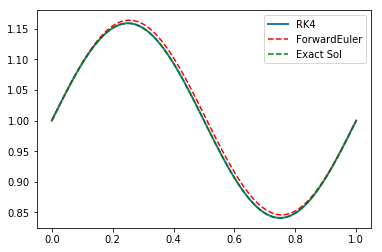

In [9]:
plt.plot(t.cpu().data.numpy(), y_rk4.cpu().data.numpy(), lw=2)
plt.plot(t.cpu().data.numpy(), y_fe.cpu().data.numpy(), 'r--')
plt.plot(t.cpu().data.numpy(), y_exact.cpu().data.numpy(), 'g--')
plt.legend(('RK4', 'ForwardEuler', 'Exact Sol'))

Text(0.5, 1.0, 'Pointwise Errors')

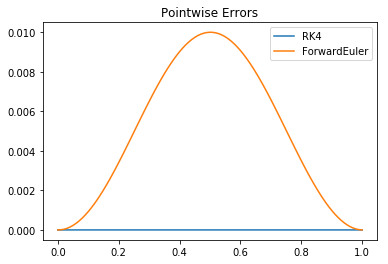

In [10]:
plt.plot(t.cpu().data.numpy(), torch.abs(y_rk4-y_exact).cpu().data.numpy())
plt.plot(t.cpu().data.numpy(), torch.abs(y_fe-y_exact).cpu().data.numpy())
plt.legend(('RK4', 'ForwardEuler'))
plt.title('Pointwise Errors')

## Use simple embedding to learn initial condition $y_0$ or $z_{t_0}$ in time series context.

In [11]:
class InitialCondRNN(nn.Module):      
    def __init__(self, num_ts, num_params):
        super(InitialCondRNN, self).__init__()  
        self.num_ts = num_ts # cardinality = number of time series = 1 for now
        self.num_params = num_params
        self.embedding = nn.Embedding(num_ts, num_params)
    
    def forward(self, f, t):
        y0 = self.embedding(torch.arange(self.num_ts))
        return ode_solver(f, t, y0.squeeze(0), solver)

In [12]:
t.shape

torch.Size([101])

In [26]:
num_ts = 1
num_params = 1 #learning only initial condition
model = InitialCondRNN(num_ts, num_params)
optimizer = torch.optim.Adam(model.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)


num_epochs = 1500
solver = 'rk4'
loss_fun = torch.nn.MSELoss()

tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    #forward pass
    y = model(f, t)
    Loss = loss_fun(y, y_exact)
    optimizer.zero_grad()
    Loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(Loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Text(0.5, 0, 't')

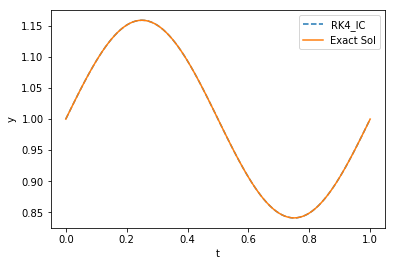

In [15]:
plt.plot(t.cpu().data.numpy(), y.cpu().data.numpy(), '--')
plt.plot(t.cpu().data.numpy(), y_exact.cpu().data.numpy())
plt.legend(('RK4_IC', 'Exact Sol'))
plt.ylabel('y')
plt.xlabel('t')

## Use simple embedding to learn initial condition $y_0$ or $z_{t_0}$ and in time series context and the function $f(t,y)$

In [17]:
class InitialCond_and_FC(nn.Module):
    def __init__(self, num_ts, num_params, solver, num_hidden=128, num_vars = 2):
        super(InitialCond_and_FC, self).__init__()
        self.num_ts = num_ts 
        self.num_params = num_params
        self.num_vars = num_vars #(t,y)
        self.solver=solver
        self.num_hidden = num_hidden
        self.dynamics = nn.Sequential(
            nn.Linear(self.num_vars, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_ts)
        )
        #self.embedding = nn.Embedding(num_ts, num_params)
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[1]]))
    # RK4
    def forward(self, t):
        y0 = self.y0#self.embedding(torch.arange(self.num_ts).to(device))
        # inline Rk4 solver
        y = []
        # Inital condiiton
        y.append(y0)
        if self.solver == 'rk4':
            for n in range(len(t)-1):
               # print(t[n].reshape(1,1).shape, y[n].shape,torch.cat([t[n].reshape(1,1), y[n]]).shape)
                
                f1 = self.dynamics(torch.cat([t[n].reshape(1,1), y[n]], dim = 1))#.reshape(self.num_ts,self.num_vars))
                k1 = dt * f1
                f2 = self.dynamics(torch.cat([(t[n] + dt/2).reshape(1,1), y[n] + k1/2], dim = 1))#.reshape(self.num_ts,self.num_vars))
                k2 = dt * f2
                f3 = self.dynamics(torch.cat([(t[n] + dt/2).reshape(1,1), y[n] + k2/2], dim = 1))#.reshape(self.num_ts,self.num_vars))
                k3 = dt * f3
                f4 = self.dynamics(torch.cat([(t[n] + dt).reshape(1,1), y[n] + k3], dim = 1))#.reshape(self.num_ts,self.num_vars))
                k4 = dt * f4
                y.append(y[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4))
                
        elif self.solver == 'forward_euler':
            for n in range(len(t)-1):
                y.append(y[n] + dt * self.dynamics(torch.cat([t[n].reshape(1,1), y[n]], dim = 1)))#, t[n].reshape(1,1)**2, y[n]**2
        else:
            print('ODE solver is not supported!')
        return torch.cat(y, dim = 1)[0]
    
    
num_ts = 1
num_params = 1 #learning only initial condition
solver = 'rk4'#'#'forward_euler
model = InitialCond_and_FC(num_ts, num_params, num_hidden = 128, solver = solver).to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)

num_epochs = 1000
t = torch.arange(0, 1+0.01, 0.01).float()
loss_fun = torch.nn.MSELoss()

tqdm_epochs = tqdm(range(num_epochs))

for e in tqdm_epochs:
    #forward pass
    y_euler = model(t.to(device))
    loss = loss_fun(y_euler.to(device), y_exact[:101].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [19]:
t = torch.arange(0, 1+0.01, 0.01).float()
y_euler = model(t.to(device))

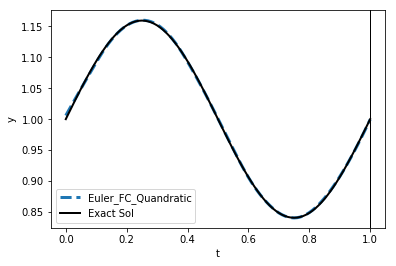

In [20]:
# after 4500 iterations loss no longer decreasing not converging!
# seems to be converging to linear function
plt.plot(t.cpu().data.numpy(), y_euler.cpu().data.numpy(), '--',linewidth = 3)
#plt.plot(t.cpu().data.numpy(), y_rk4.cpu().data.numpy(), '--',linewidth = 3, color = "red")
plt.plot(t.cpu().data.numpy(), y_exact.cpu().data.numpy(), color = "black",linewidth = 2)
plt.axvline(1, color = "black",linewidth = 1)
plt.legend(('Euler_FC_Quandratic', 'Exact Sol'))#  'RK4_FC',
plt.xlabel('t')
plt.ylabel('y');
#plt.savefig("Cosine_Quan_Extrapolation.png", dpi = 300 , bbox_inches = "tight")

## Fully connected

In [21]:
class FC(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FC, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)
        )
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[0]]))
    def forward(self, t):
        y_preds = [self.y0]
        for i in range(1,len(t)):
            y_preds.append(self.model(t[i].reshape(1,1)))
        return torch.cat(y_preds, dim = -1)

In [22]:
model_fc = FC(input_dim = 1, hidden_dim = 1024).cuda()

In [23]:
optimizer = torch.optim.Adam(model_fc.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)
num_epochs = 1000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))

min_loss = 10

for e in tqdm_epochs:
    #forward pass
    y = model_fc(t.to(device))[0]
    loss = loss_fun(y, y_exact.to(device))
    if loss.item() < min_loss:
        best_model = model_fc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


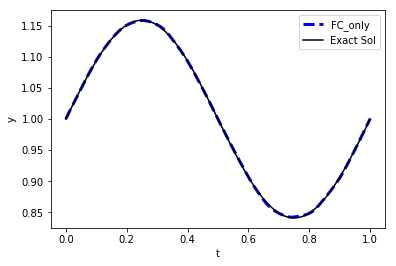

In [29]:
y = best_model(t.to(device))[0]
# after 4500 iterations loss no longer decreasing not converging!
# seems to be converging to linear function
plt.plot(t.cpu().data.numpy(), y.cpu().data.numpy(), '--',linewidth = 3, color = "blue")
plt.plot(t.cpu().data.numpy(), y_exact.cpu().data.numpy(), color = "black")
plt.legend(('FC_only', 'Exact Sol'))
plt.xlabel('t')
plt.ylabel('y')
#plt.savefig("Cosine_FC.png", dpi = 300 , bbox_inches = "tight")

## LSTM
RNN with 25 hidden units with a 4D latent space $\bf{z}_{t_i} \in \mathbb{R}^4$ and 2D observation space $\bf{x}_{t_i} \in \mathbb{R}^2$

In [149]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first = True)
        self.output_layer = nn.Linear(self.hidden_dim, 1)
        self.y0 = torch.nn.Parameter(torch.cuda.FloatTensor([[[1]]]))
        
    def forward(self, target_length, y_exact):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        y_preds = [self.y0]
        hidden_states = [torch.zeros(self.num_layers,1,self.hidden_dim),torch.zeros(self.num_layers,1,self.hidden_dim)]
        outputs, hidden_states = self.lstm(self.y0)
        y_preds.append(self.output_layer(outputs))
        for i in range(1, target_length):
            #print(outputs.shape, hidden_states[0].shape, y_preds[i].shape)
            outputs, hidden_states = self.lstm(y_exact[i].reshape(1,1,1), hidden_states)
            y_preds.append(self.output_layer(outputs))
        return torch.cat(y_preds, dim = -1)

In [150]:
#, y_preds[i]][np.random.randint(2,size = 1)[0]]

In [151]:
model_lstm = LSTM(input_dim = 1, hidden_dim = 1024, num_layers = 3).cuda()
optimizer = torch.optim.SGD(model_lstm.parameters(), 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.9)

In [152]:
num_epochs = 1000
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10
for e in tqdm_epochs:
    #forward pass
    y = model_lstm(100, y_exact.to(device))[0,0]
    loss = loss_fun(y, y_exact.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if loss.item() < min_loss:
        best_model = model_lstm
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


KeyboardInterrupt: 

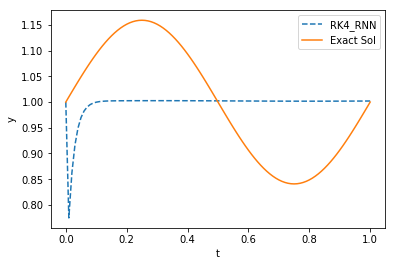

In [153]:
y = best_model(100, y_exact.to(device))[0,0]
# after 4500 iterations loss no longer decreasing not converging!
# seems to be converging to linear function
plt.plot(t.cpu().data.numpy(), y.cpu().data.numpy(), '--')
plt.plot(t.cpu().data.numpy(), y_exact.cpu().data.numpy())
plt.legend(('RK4_RNN', 'Exact Sol'))
plt.xlabel('t')
plt.ylabel('y');